## Py-DDA example notebook

This notebooks shows how you can get multiple Doppler winds from different radars. All that is needed are Cf-Compliant grids that share the same grid specifications. Tools such as Python ARM Radar Toolkit (Py-ART) (https://github.com/ARM-DOE/pyart) and LROSE (https://www.eol.ucar.edu/content/lidar-radar-open-software-environment) can create these grids for you. 

The PyDDA package is built on top of Py-ART. Therefore, Py-ART is needed for PyDDA to run. 

In [6]:
import pyart
import pydda
%pylab inline
import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/rjackson/.local/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/rjackson/.local/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/rjackson/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


First, we load our Cf-Compliant grids using Py-ART's read_grid function.

In [8]:
berr_grid = pyart.io.read_grid("/home/rjackson/data/berr_Darwin.nc")
cpol_grid = pyart.io.read_grid("/home/rjackson/data/cpol_Darwin.nc")
print(cpol_grid.fields.keys())

dict_keys(['AZ', 'EL', 'VT', 'ROI', 'DT'])


Next, we must specify the initial conditions. PyDDA currently has two options for the intial state:

    * pydda.retrieval.make_wind_field_from_profile - Make the intialization wind field be that from a sounding    
    * pydda.retrieval.make_constant_wind_field - Specify a constant wind field 
    
More options will be added in the future! In this example, we will load data from a sounding and use that as our intial state with no vertical motion. 
    

In [10]:
sounding = pyart.io.read_arm_sonde(
    "/lcrc/group/earthscience/rjackson/soundings/twpsondewnpnC3.b1.20060119.231600.custom.cdf")
print(sounding)
u_init, v_init, w_init = pydda.initialization.make_wind_field_from_profile(
        cpol_grid, sounding[1], vel_field='VT')

(datetime.datetime(2006, 1, 19, 23, 16), <pyart.core.wind_profile.HorizontalWindProfile object at 0x2b1036ca1cc0>)


Next, we will retrieve the wind field! The output of these is a list of Py-ART Grids which correspond to the inputs with the wind fields added in. 

In [11]:
Grids = pydda.retrieval.get_dd_wind_field([berr_grid, cpol_grid], u_init,
                                          v_init, w_init, Co=100.0, Cm=1500.0, 
                                          Cz=0, vel_name='VT', refl_field='DT',
                                          frz=5000.0, filt_iterations=0, 
                                          mask_outside_opt=True, upper_bc=1)

Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 39.80212965083738
Total points:182639.0
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|  15.0369| 225.6660|   0.0000|   0.0000|   0.0000|   0.0000|   8.0398
Norm of gradient: 0.01950807364406606
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|   5.7461|  72.1230|   0.0000|   0.0000|   0.0000|   0.0000|   9.0788
Norm of gradient: 0.017521984093309996
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|   2.8821|  44.9406|   0.0000|   0.0000|   0.0000|   0.0000|  12.1518
Norm of gradient: 0.017918990922263418
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|   1.1829|  35.1937|   0.0000|   0.0000|   0.0000|   0.0000|  16.2463
Norm of gradient: 0.01039821006802568
Iterations before filter: 40
| Jvel    | Jmass   | Jsmooth | 

Let's save our grid so we don't have to regenerate it again!

In [12]:
pyart.io.write_grid('example_grid_radar0.nc', Grids[0])
pyart.io.write_grid('example_grid_radar1.nc', Grids[1])

In [13]:
Grids = [pyart.io.read_grid('example_grid_radar0.nc'), pyart.io.read_grid('example_grid_radar1.nc')]

Finally, we will visualize the wind field. This is easy with the visualization module of PyDDA! PyDDA currently has support to plot wind barb plots through xy, xz, and yz cross sections. More types of plots (streamline plots, plots on geospatial grids) are planned as future features.

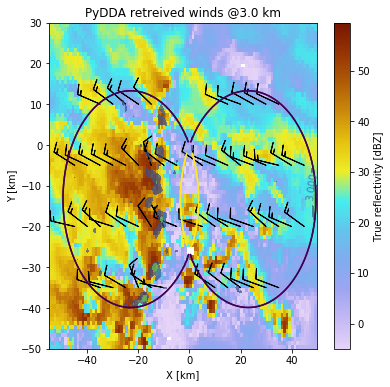

In [14]:
plt.figure(figsize=(6,6))
pydda.vis.plot_horiz_xsection_barbs(Grids, None, 'DT', level=6,
                                    w_vel_contours=[3, 6, 9],
                                    barb_spacing_x_km=5.0,
                                    barb_spacing_y_km=15.0)

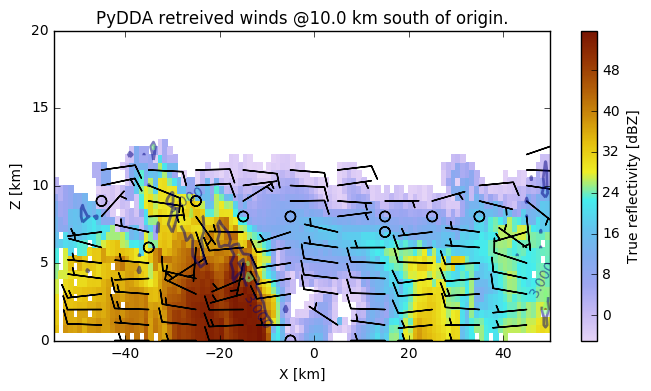

In [8]:
plt.figure(figsize=(8,4))
pydda.vis.plot_xz_xsection_barbs(Grids, None, 'DT', level=40,
                                 w_vel_contours=[3, 6, 9],
                                 barb_spacing_x_km=10.0,
                                 barb_spacing_z_km=2.0)

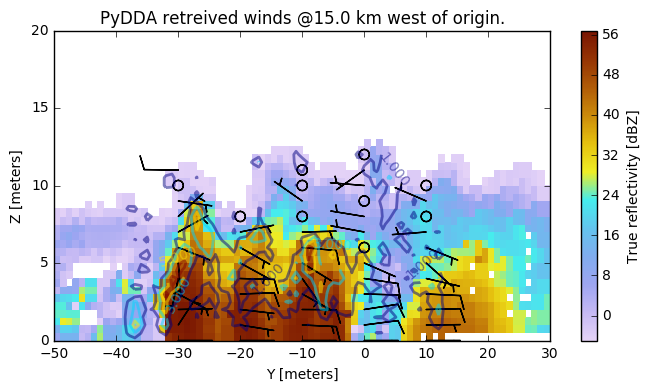

In [9]:
plt.figure(figsize=(8,4))
pydda.vis.plot_yz_xsection_barbs(Grids, None,'DT', level=40,
                                 w_vel_contours=[1, 3, 5, 7],
                                 barb_spacing_y_km=10.0,
                                 barb_spacing_z_km=2.0)

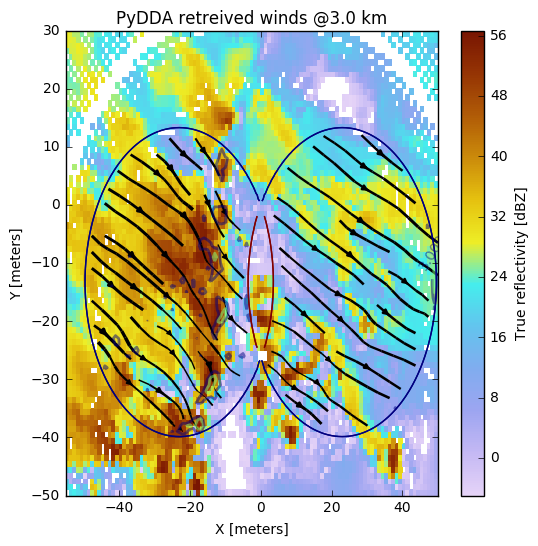

In [10]:
plt.figure(figsize=(6,6))
pydda.vis.plot_horiz_xsection_streamlines(Grids, None, 'DT', level=6,
                                          w_vel_contours=[3, 6, 9],
                                          )

(0, 15)

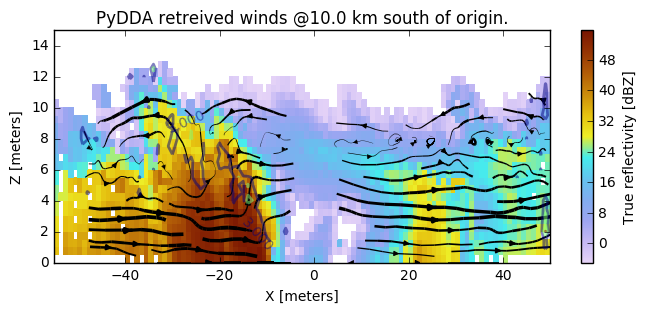

In [13]:
plt.figure(figsize=(8,3))
pydda.vis.plot_xz_xsection_streamlines(Grids, None, 'DT', level=40,
                                 w_vel_contours=[3, 6, 9],
                                 thickness_divisor=5.0)
plt.ylim([0,15])

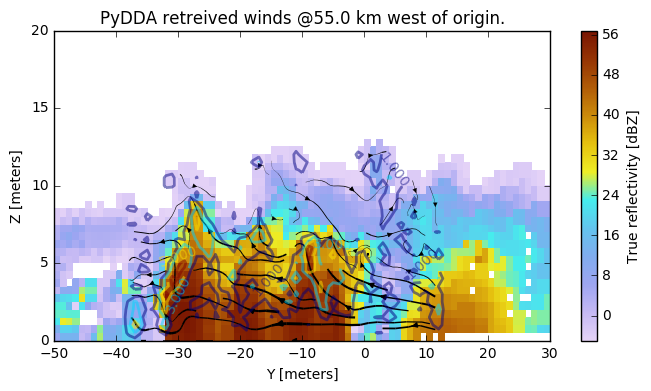

In [12]:
plt.figure(figsize=(8,4))
pydda.vis.plot_yz_xsection_streamlines(Grids, None,'DT', level=40,
                                 w_vel_contours=[1, 3, 5, 7],
                                 )

## Doing a retrieval on a cluster

In [15]:
from distributed import Client, LocalCluster

Start a dask distributed cluster. If you are running a retrieval on more than one machine, we 
highly recommend the use of dask-jobqueue for setting up your cluster. 

Dask-jobqueue is available here:
https://jobqueue.dask.org/en/latest/

In [16]:
# Can also use something like dask-jobqueue to set up your cluster - this is for one machine 
cluster = LocalCluster(n_workers=2, processes=True)
client = Client(cluster)

In [17]:
client

Client Scheduler: tcp://127.0.0.1:37928 Dashboard: http://127.0.0.1:35184/status,Cluster Workers: 2 Cores: 36 Memory: 135.08 GB


get_dd_wind_field_nested takes in the same parameters as get_dd_wind_field, except for a distributed client after w_init as a required entry.

In [18]:
Grids = pydda.retrieval.get_dd_wind_field_nested([berr_grid, cpol_grid], u_init,
                                                 v_init, w_init, client, Co=100.0, Cm=1500.0, 
                                                 Cz=0, vel_name='VT', refl_field='DT',
                                                 frz=5000.0, filt_iterations=0, 
                                                 mask_outside_opt=True, upper_bc=1)

Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 39.92278929507569
Total points:45716.0
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|   1.9670|  33.2490|   0.0000|   0.0000|   0.0000|   0.0000|   7.8962
Norm of gradient: 0.014861080295562209
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|   0.5623|  10.0446|   0.0000|   0.0000|   0.0000|   0.0000|   5.8383
Norm of gradient: 0.010963209014423504
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|   0.5167|   5.5866|   0.0000|   0.0000|   0.0000|   0.0000|   5.7344
Norm of gradient: 0.025860071823156514
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|   0.0790|   3.9307|   0.0000|   0.0000|   0.0000|   0.0000|   5.9397
Norm of gradient: 0.003845449734782642
Iterations before filter: 40
| Jvel    | Jmass   | Jsmooth |

In [19]:
pyart.io.write_grid('example_grid_radar0.nc', Grids[0])
pyart.io.write_grid('example_grid_radar1.nc', Grids[1])

In [20]:
Grids = [pyart.io.read_grid('example_grid_radar0.nc'), pyart.io.read_grid('example_grid_radar1.nc')]

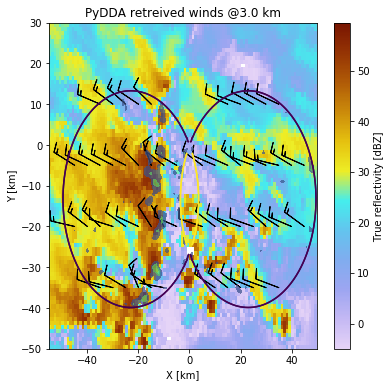

In [21]:
plt.figure(figsize=(6,6))
pydda.vis.plot_horiz_xsection_barbs(Grids, None, 'DT', level=6,
                                    w_vel_contours=[3, 6, 9],
                                    barb_spacing_x_km=5.0,
                                    barb_spacing_y_km=15.0)

NameError: name 'contour_colorbar_flag' is not defined

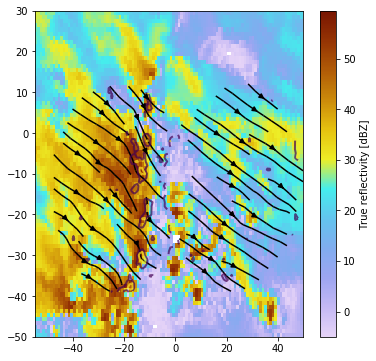

In [25]:
plt.figure(figsize=(6,6))
pydda.vis.plot_horiz_xsection_streamlines(Grids, None, 'DT', level=6,
                                          w_vel_contours=[3, 6, 9],
                                          )